In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import io
import json
import scipy.io as sio
from os import path

import PIL
from PIL import Image


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-1'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

# Layers

In [6]:
# Batchnorm epsilon
BN_EPS = 1e-4

class ConvBnRelu2d(layers.Layer):
    # Convolutional -> Batch norm -> ReLU
    
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(ConvBnRelu2d, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', use_bias=False)
        self.bn = layers.BatchNormalization(epsilon=BN_EPS)
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class StackEncoder(layers.Layer):
    # ConvBnRelu -> ConvBnRelu -> * -> max pool (2x2)
    #      * store tensor for concatenation with expansive path

    def __init__(self, y_channels, kernel_size=3):
        super(StackEncoder, self).__init__()
        self.encode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same')
        ])
        
        self.max_pool = layers.MaxPool2D(pool_size=2, strides=2)
        
    def call(self, x):
        x = self.encode(x)
        x_small = self.max_pool(x)
        return x, x_small


class StackDecoder(layers.Layer):
    # Upsample (2x) -> concatenation -> ConvBnRelu -> ConvBnRelu -> ConvBnRelu

    def __init__(self, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        self.decode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ]
        )
        
        
    def call(self, x, down_tensor):
        x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        
        # Calculate cropping for down_tensor to concatenate with x
        _, h2, w2, _ = down_tensor.shape
        _, h1, w1, _ = x.shape
        h_diff, w_diff = h2 - h1, w2 - w1
        
        cropping = ((int(np.ceil(h_diff / 2)), int(np.floor(h_diff / 2))),
                    (int(np.ceil(w_diff / 2)), int(np.floor(w_diff / 2))))
        down_tensor = layers.Cropping2D(cropping=cropping)(down_tensor)        
        x = layers.concatenate([x, down_tensor], axis=3)
        x = self.decode(x)
        return x

# Model

In [7]:
class UNet_2d(keras.Model):
    def __init__(self):
        super(UNet_2d, self).__init__()
        self.down1 = StackEncoder(24, kernel_size=3)
        self.down2 = StackEncoder(64, kernel_size=3)
        self.down3 = StackEncoder(128, kernel_size=3)
        self.down4 = StackEncoder(256, kernel_size=3)
        self.down5 = StackEncoder(512, kernel_size=3)
        self.down6 = StackEncoder(1024, kernel_size=3)

        self.up6 = StackDecoder(512, kernel_size=3)
        self.up5 = StackDecoder(256, kernel_size=3)
        self.up4 = StackDecoder(128, kernel_size=3)
        self.up3 = StackDecoder(64, kernel_size=3)
        self.up2 = StackDecoder(24, kernel_size=3)
        self.up1 = StackDecoder(24, kernel_size=3)
        
        # Final prediction uses a single feature channel (green)
        self.classify = layers.Conv2D(filters=1, kernel_size=1, use_bias=True)
        
#         self.center = ConvBnRelu2d(512, kernel_size=3, padding='same')
        self.center = ConvBnRelu2d(1024, kernel_size=3, padding='same')
        
        
    def call(self, x):
        out = x;
        down1_tensor, out = self.down1(out)
        down2_tensor, out = self.down2(out)
        down3_tensor, out = self.down3(out)
        down4_tensor, out = self.down4(out)
        down5_tensor, out = self.down5(out)
        down6_tensor, out = self.down6(out)

        out = self.center(out)
        
        out = self.up6(out, down6_tensor)
        out = self.up5(out, down5_tensor)
        out = self.up4(out, down4_tensor)
        out = self.up3(out, down3_tensor)
        out = self.up2(out, down2_tensor)
        out = self.up1(out, down1_tensor)

        out = self.classify(out)
        out = tf.squeeze(out, axis=3)
        
        return out

# Testing

In [8]:
model = UNet_2d()
model.load_weights(model_weights_path + '.e60')

In [9]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [10]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))
b_min = np.min(beads)
b_max = np.max(beads)
beads_input_normed = ((beads - b_min) / (b_max - b_min)).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [11]:
res = np.array(Image.fromarray(res).resize(obj_dims, resample=PIL.Image.NEAREST))
r_min = np.min(res)
r_max = np.max(res)
res_input_normed = ((res - r_min) / (r_max - r_min)).T
res_input = res_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [12]:
pred_beads = model.predict(beads_input).squeeze()

In [13]:
pred_res = model.predict(res_input).squeeze()

In [14]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = (beads_gt - np.min(beads_gt)) / (np.max(beads_gt) - np.min(beads_gt))

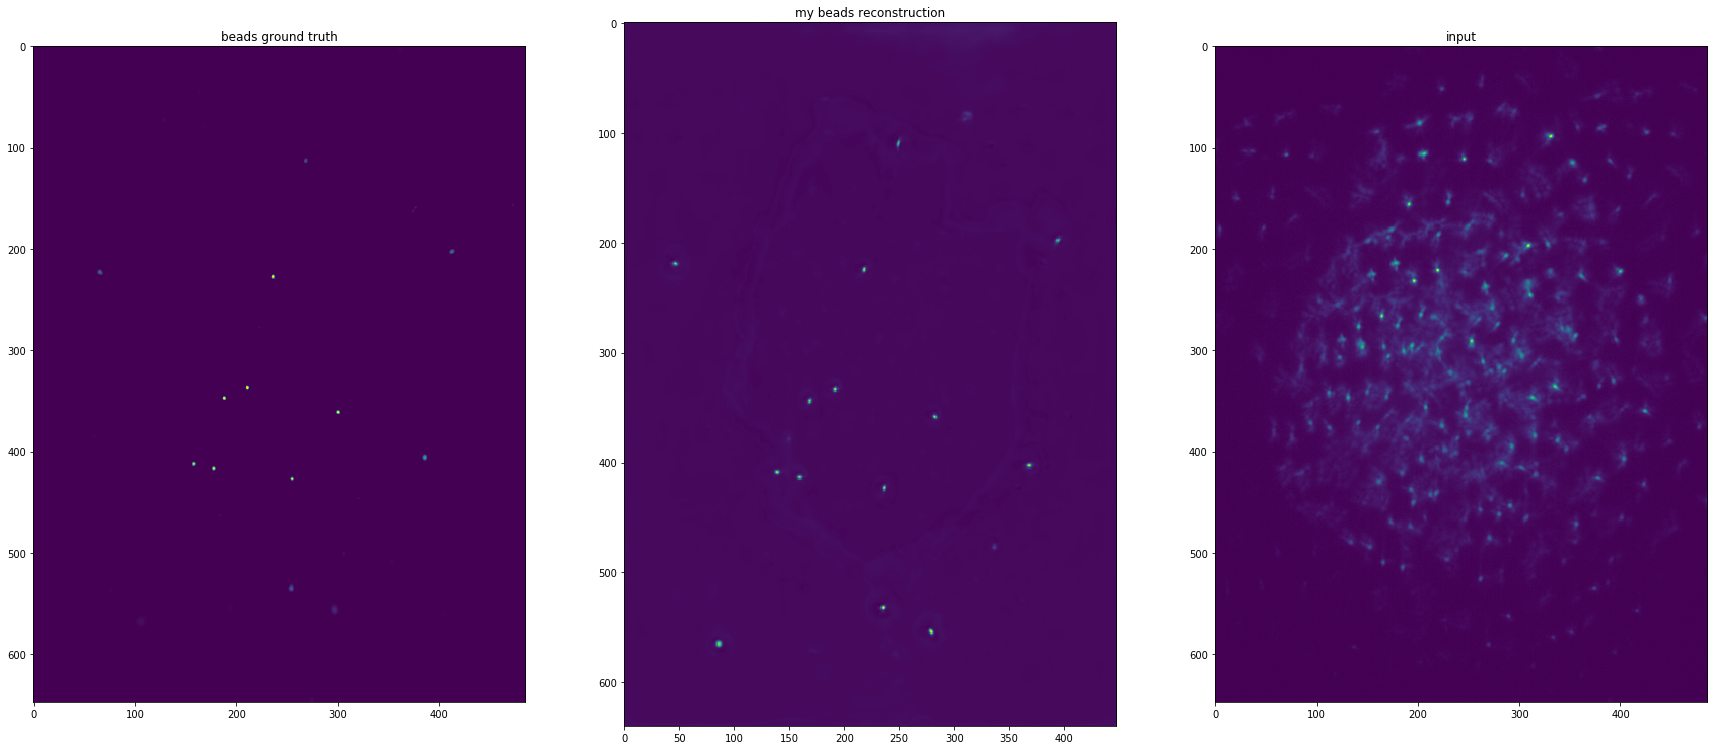

In [15]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


plt.savefig(path.join(image_path, 'beads_reconstruction.pdf'))
plt.show()


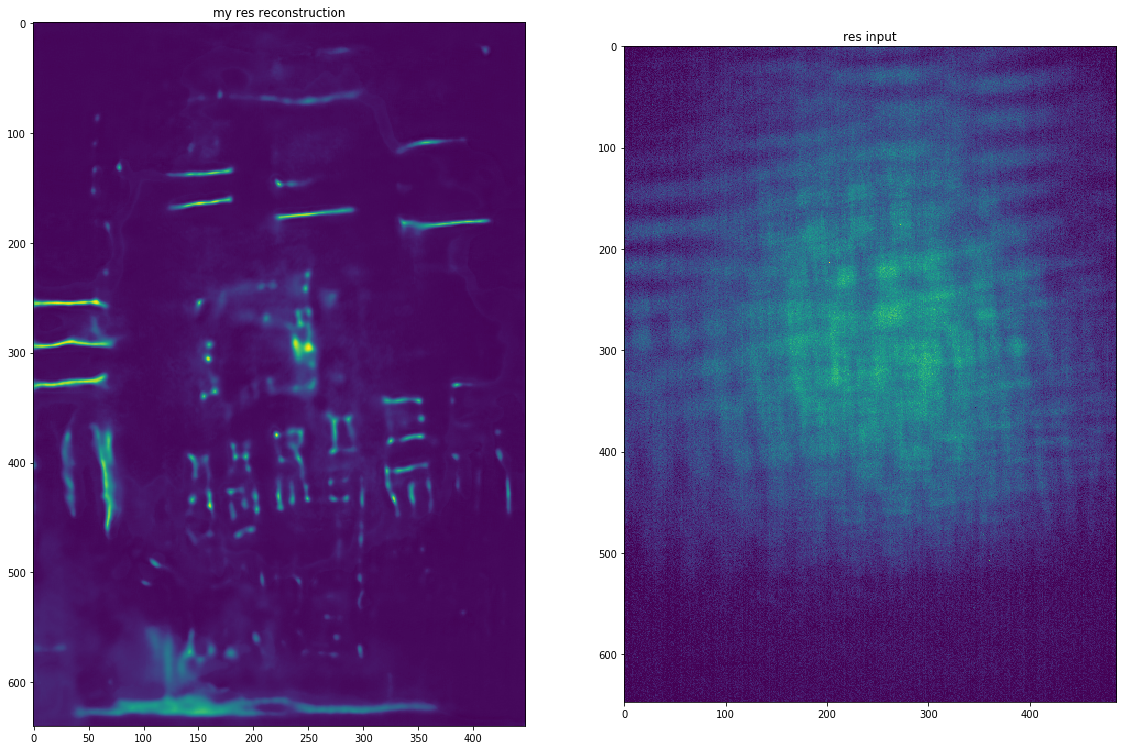

In [16]:
fig = plt.figure(figsize=(30, 30))
f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my res reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_res)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('res input')
f2.imshow(res_input_normed)

plt.savefig(path.join(image_path, 'res_reconstruction.pdf'))

plt.show()

In [17]:
np.sum(pred_beads)

1022.8976

In [18]:
np.sum(beads_gt)

86.24705882352941